In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.colors import LogNorm


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import SmoothBivariateSpline  # or griddata / RBFInterpolator

# from cosipy import UnBinnedData, BinnedData


# For Yannis: MDP given flux and duration

In [314]:
Edges = np.array([100.,158.489,251.189,398.10,
         630.957,1000.,1584.89,2511.89,
         3981.07,6309.57,10000.]) #keV
E_ = np.sqrt(Edges[:-1] * Edges[1:])
average_aeff = np.array([2.53242116,  9.98862738, 15.56999905, 15.84875499, 
                14.13861744, 11.91851854,9.34862497, 6.2098249,  
                4.43089929,  2.45646035]) #cm2
COSI_aeff_spline = interp1d(E_, average_aeff)

def get_K(integrated_flux,gamma,emin=200, emax=5000):
    K = integrated_flux * (-gamma+1) / (emax**(-gamma+1)-emin**(-gamma+1)) 
    return K

def keV2erg( ene_keV):
    ene_erg = ene_keV * 1.60218e-9
    return ene_erg

def get_Eflux_ergcm2s( K, gamma=1.5, emin=200, emax=5000):
    #intergrated energy flux between emin and emax
    Eflux = K * (emax**(-gamma+2)-emin**(-gamma+2)) / (-gamma+2)
    #erg conversion
    Eflux = Eflux * keV2erg(1)
    return Eflux 

def get_diff_spectrum_spline(ene_, K, gamma):
    s = K * ene_**(-gamma)
    s_spline = interp1d(ene_, s)
    return s_spline

def fold_spec_aeff(ene_, spec_spline, aeff_spline):
    s_folded = spec_spline(ene_) * aeff_spline(ene_)
    s_folded_spline = interp1d(ene_, s_folded)
    return s_folded_spline

def get_counts(ene_, s_folded_spline, duration_weeks):
    duration_sec = duration_weeks * 7 * 24 * 60 * 60
    total_rate = np.trapz(s_folded_spline(ene_), x=ene_)
    total_counts = total_rate * duration_sec
    return total_counts

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    mdp99 = 4.29/average_mu * np.sqrt(src_counts+bkg_counts)/(src_counts) * 100
    return mdp99

def get_mdp_fluxXindex_plot__(fine_ene_array, gamma_array, flux_200_5000_array, flare_duration_week=1, bkg_rate=1, aeff_spline=COSI_aeff_spline, save_plot=False):

    bkg_cnts = bkg_rate * 0.25 * flare_duration_week * 7 * 24 * 60 * 60
    _mdp_ = []
    _k_ = []
    _cnts_ = []
    print( flux_200_5000_array.min(), flux_200_5000_array.max())
    for intflux in flux_200_5000_array:
        _mdp = []
        _k = []
        _cnts = []
        for g in gamma_array:
            k = get_K(intflux, g)
            _k.append(k)
            # print('K', k)
            spec = get_diff_spectrum_spline(fine_ene_array, k, g)
            fold_spec = fold_spec_aeff(fine_ene_array, spec, aeff_spline)
            cnts = get_counts(fine_ene_array, fold_spec, flare_duration_week)
            mdp = ComputeMDP99(cnts, bkg_cnts)
            # print('Bkg cnts = ', bkg_cnts, 'Src cnts = ', cnts, 'MDP99 = ', mdp)
            _mdp.append(mdp)
            _cnts.append(cnts)
        _mdp_.append(_mdp)
        _k_.append(_k)
        _cnts_.append(_cnts)
    _mdp_ = np.array(_mdp_)
    _k_ = np.array(_k_)
    _cnts_ = np.array(_cnts_)

    #plot matrix:
    plt.figure()
    plt.title(r'MDP(flux, index) -- R$_{bkg}$=%.2f cnt/s, $\Delta t_{flare}$=%i week(s)'%(bkg_rate, flare_duration_week))
    plt.imshow(_mdp_, origin='lower', aspect='auto', cmap='gist_earth', vmin=0.01, vmax=100,
               extent=[gamma_array[0], gamma_array[-1], flux_200_5000_array.min(), flux_200_5000_array.max()])
    plt.colorbar(label='MDP99 [%]')
    plt.yscale('log')
    plt.xlabel(r'$\Gamma$')
    plt.ylabel('0.2-5 MeV Average flare flux [ph/cm2/s]')

    if save_plot:
        plt.savefig('MDP_fluxXindex_Rbkg%.2f_Duration%i.png'%(bkg_rate, flare_duration_week), dpi=300)

    return _mdp_, _k_, _cnts_

def get_mdp_fluxXindex_plot(fine_ene_array,
                            gamma_array,
                            flux_200_5000_array,
                            flare_duration_week=1,
                            bkg_rate=1,
                            aeff_spline=COSI_aeff_spline,
                            save_plot=False):

    # background counts over the flare duration
    bkg_cnts = bkg_rate * 0.25 * flare_duration_week * 7 * 24 * 60 * 60

    _mdp_ = []
    _k_ = []
    _cnts_ = []

    print(flux_200_5000_array.min(), flux_200_5000_array.max())

    for intflux in flux_200_5000_array:
        _mdp_row = []
        _k_row = []
        _cnts_row = []
        for g in gamma_array:
            k = get_K(intflux, g)
            _k_row.append(k)

            spec = get_diff_spectrum_spline(fine_ene_array, k, g)
            fold_spec = fold_spec_aeff(fine_ene_array, spec, aeff_spline)
            cnts = get_counts(fine_ene_array, fold_spec, flare_duration_week)
            mdp = ComputeMDP99(cnts, bkg_cnts)

            _mdp_row.append(mdp)
            _cnts_row.append(cnts)

        _mdp_.append(_mdp_row)
        _k_.append(_k_row)
        _cnts_.append(_cnts_row)

    _mdp_ = np.array(_mdp_)   # shape: (n_flux, n_gamma)
    _k_ = np.array(_k_)
    _cnts_ = np.array(_cnts_)

    # coordinate grids: gamma on x, flux on y
    gam = gamma_array
    flux = flux_200_5000_array
    G, F = np.meshgrid(gam, flux)

    # plot matrix
    plt.figure()
    plt.title(r'MDP(flux, index) -- R$_{bkg}$=%.2f cnt/s, $\Delta t_{flare}$=%i week(s)'
              % (bkg_rate, flare_duration_week))

    # use pcolormesh so coordinates are handled explicitly
    pcm = plt.pcolormesh(G, F, _mdp_,
                         shading='auto',
                         cmap='gist_earth',
                         vmin=0.01, vmax=100)
    plt.colorbar(pcm, label='MDP99 [%]')

    plt.yscale('log')
    plt.xlabel(r'$\Gamma$')
    plt.ylabel('0.2–5 MeV Average flare flux [ph/cm$^2$/s]')

    if save_plot:
        plt.savefig('MDP_fluxXindex_Rbkg%.2f_Duration%i.png'
                    % (bkg_rate, flare_duration_week), dpi=300)

    return _mdp_, _k_, _cnts_

def get_mdp_fluxXduration_plot(fine_ene_array, flux_200_5000_array, flare_duration_week_array,
                               gamma=2.5, bkg_rate=1, aeff_spline=COSI_aeff_spline, save_plot=False):
    _mdp_ = []
    for intflux in flux_200_5000_array:
        _mdp = []
        for d in flare_duration_week_array:
            bkg_cnts = bkg_rate * 0.25 * d * 7 * 24 * 60 * 60
            k = get_K(intflux, gamma)
            spec = get_diff_spectrum_spline(fine_ene_array, k, gamma)
            fold_spec = fold_spec_aeff(fine_ene_array, spec, aeff_spline)
            cnts = get_counts(fine_ene_array, fold_spec, d)
            mdp = ComputeMDP99(cnts, bkg_cnts)
            _mdp.append(mdp)
        _mdp_.append(_mdp)
    _mdp_ = np.array(_mdp_)

    dur = flare_duration_week_array
    flux = get_Eflux_ergcm2s(flux_200_5000_array)
    D, F = np.meshgrid(dur, flux)

    #find and print the flux valued at MDP=5% for 2 and 4 weeks
    plt.figure()
    print('For Bkg Rate =', bkg_rate, 'cnts/s')
    for target_d in [2., 4.]:
        d_index = np.where(flare_duration_week_array == target_d)[0]
        mdp_column = _mdp_[:, d_index]
        Efluxvsmdp_t = interp1d(mdp_column.flatten(), flux)
        eflux_at_mdp5 = Efluxvsmdp_t(5.)
        print('For duration = %.1f weeks, Flux at MDP=5%%: %.2e erg/cm2/s' % (target_d, eflux_at_mdp5))
        #plot the spline
        
        plt.plot(mdp_column.flatten(), flux)
        plt.vlines(5, flux.min(), flux.max(), colors='r', linestyles='--')
        plt.xlabel('MDP99')
        plt.xlim(0,10)
        plt.ylim(1e-10, 1e-8)
        plt.yscale('log')
        plt.ylabel('Energy Flux [erg/cm2/s]')

    plt.figure()
    plt.title(r'$\Gamma=-$%.1f, R$_{bkg}$=%.2f cnt/s' % (gamma, bkg_rate))

    # Background color map: use pcolormesh with actual coordinates
    pcm = plt.pcolormesh(D, F, _mdp_, shading='auto',
                         cmap='gist_earth', vmin=0.01, vmax=100)
    plt.colorbar(pcm, label='MDP99 [%]')

    # Contours in the SAME (duration, flux) coordinates
    cs = plt.contour(D, F, _mdp_, levels=[1, 5, 50, 100],
                     colors='w', linewidths=1)
    plt.clabel(cs, inline=1, fontsize=10, fmt=r'%1.0f%% $MDP_{99}$')

    cs = plt.contour(D, F, _mdp_, levels=[100],
                     colors='0.3', linewidths=1)
    plt.clabel(cs, inline=1, fontsize=10, fmt=r'%1.0f%% $MDP_{99}$')
    #add vertical lines for 2 and 4 weeks
    plt.axvline(x=2, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=4, color='gray', linestyle='--', linewidth=1)

     # Log scale for flux
    plt.yscale('log')
    plt.xlabel(r'$\Delta t_{flare}$ [weeks]')
    plt.ylabel('0.2–5 MeV Average flare flux [erg/cm$^2$/s]')
    plt.grid(which='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    if save_plot:
        plt.savefig('MDP_fluxXduration_Rbkg%.2f_Gamma%.1f.png' % (bkg_rate, gamma), dpi=300)

    return _mdp_

def get_mdp_fluxXduration_plot__(fine_ene_array, flux_200_5000_array, flare_duration_week_array, gamma = 2.5, bkg_rate=1, aeff_spline=COSI_aeff_spline, save_plot=False):
    _mdp_ = []
    for intflux in flux_200_5000_array:
        _mdp = []
        for d in flare_duration_week_array:
            bkg_cnts = bkg_rate * 0.25 * d * 7 * 24 * 60 * 60
            k = get_K(intflux, gamma)
            # print('D', d)
            spec = get_diff_spectrum_spline(fine_ene_array, k, gamma)
            fold_spec = fold_spec_aeff(fine_ene_array, spec, aeff_spline)
            cnts = get_counts(fine_ene_array, fold_spec, d)
            mdp = ComputeMDP99(cnts, bkg_cnts)
            # print('Bkg cnts = ', bkg_cnts, 'Src cnts = ', cnts, 'MDP99 = ', mdp)
            _mdp.append(mdp)
        _mdp_.append(_mdp)
    _mdp_ = np.array(_mdp_)

    #plot matrix:
    print( flux_200_5000_array.min(), flux_200_5000_array.max())
    plt.figure()
    plt.title(r'MDP(flux, duration) -- R$_{bkg}$=%.2f cnt/s'%(bkg_rate))
    # colorscale logarithmic
    # plt.yscale('log')
    # plt.xscale('log')
    plt.imshow(_mdp_, origin='lower', aspect='auto', cmap='gist_earth', vmin=0.01, vmax=100,
               extent=[flare_duration_week_array.min(), flare_duration_week_array.max(), flux_200_5000_array.min(), flux_200_5000_array.max()])
    plt.colorbar(label='MDP99 [%]')
    #mark the 10%, 30%, 60%  MDP contour
    cs = plt.contour(_mdp_, levels=[1, 10, 50, 100], colors='0.7', linewidths=1, extent=[ flare_duration_week_array.min(), flare_duration_week_array.max(), flux_200_5000_array.min(), flux_200_5000_array.max()])
    plt.clabel(cs, inline=1, fontsize=10, fmt=r'%1.0f%% $MDP_{99}$')

    plt.xlabel(r'$\Delta t_{flare}$ [weeks]')
    plt.ylabel('0.2-5 MeV Average flare flux [ph/cm2/s]')
    #clip the y-axis to 1e-4 to 1e0
    # plt.ylim(1e-2, flux_200_5000_array.max())

    # add a faint grid both minor and major
    plt.grid(which='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    if save_plot:
        plt.savefig('MDP_fluxXduration_Rbkg%.2f_Gamma%.1f.png'%(bkg_rate, gamma), dpi=300)
    return _mdp_


[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.
 4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]
1e-05 1.0
For Bkg Rate = 1 cnts/s
For duration = 2.0 weeks, Flux at MDP=5%: 2.41e-09 erg/cm2/s
For duration = 4.0 weeks, Flux at MDP=5%: 1.58e-09 erg/cm2/s
For Bkg Rate = 0.05 cnts/s
For duration = 2.0 weeks, Flux at MDP=5%: 1.12e-09 erg/cm2/s
For duration = 4.0 weeks, Flux at MDP=5%: 6.24e-10 erg/cm2/s
(160, 50)


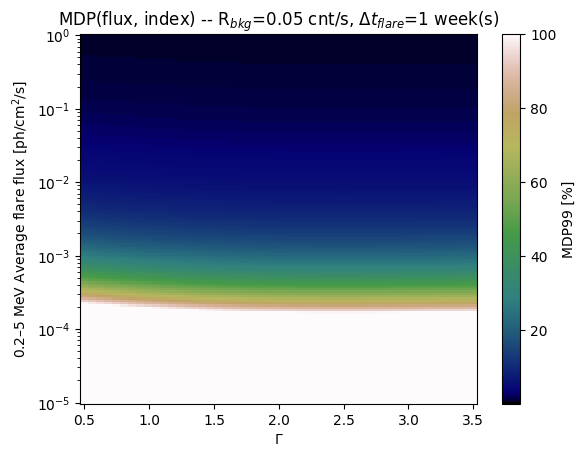

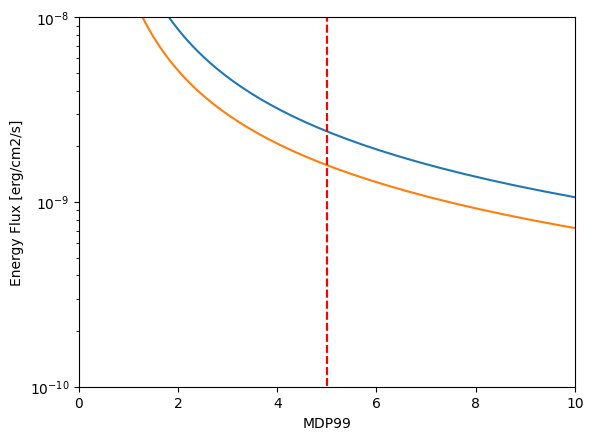

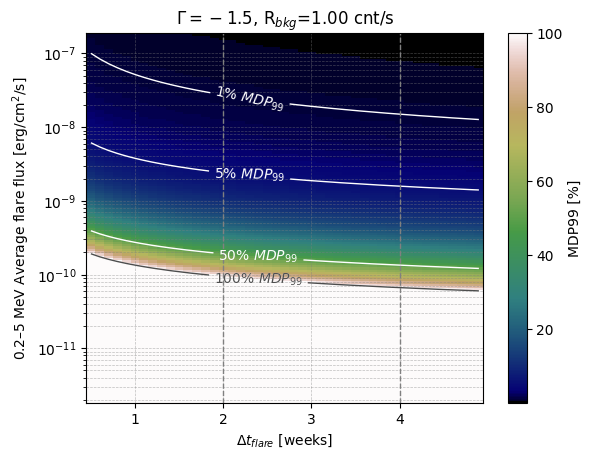

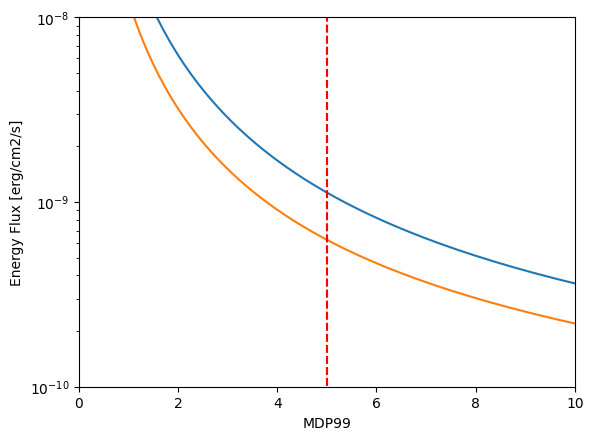

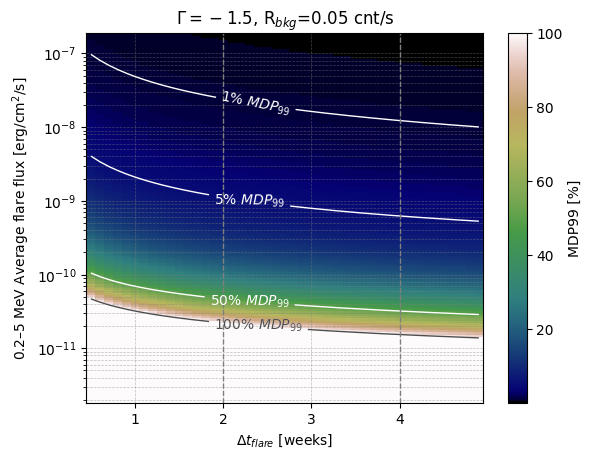

In [315]:
fine_ene_ = np.logspace(np.log10(200), np.log10(5000), 1000)
gamma_ = np.linspace(0.5, 3.5, 50)
flux_200_5000_ = np.logspace(-5, 0, 160)
flare_dur_ = np.arange(0.5,5, 0.1)#np.linspace(0.5,5,50)
# force flare duration to have float type with 1 decimal
flare_dur_ = np.round(flare_dur_, 1).astype(float)
print(flare_dur_)

_mdp_, _k_, _cnts_ = get_mdp_fluxXindex_plot(fine_ene_, gamma_, flux_200_5000_, flare_duration_week=1, bkg_rate=0.05, aeff_spline=COSI_aeff_spline, save_plot=True)
_mdp_2 = get_mdp_fluxXduration_plot(fine_ene_, flux_200_5000_, flare_duration_week_array=flare_dur_, gamma=1.5, bkg_rate=1, aeff_spline=COSI_aeff_spline, save_plot=True)
_mdp_2 = get_mdp_fluxXduration_plot(fine_ene_, flux_200_5000_, flare_duration_week_array=flare_dur_, gamma=1.5, bkg_rate=0.05, aeff_spline=COSI_aeff_spline, save_plot=True)

print(_mdp_.shape)
plt.show()
# plt.step(Edges[:-1], average_aeff, where='post')
# plt.xscale('log')

# For Marco: test methods

64
Average Aeff COSI: 20767.160122503497
Average Aeff LAT * Rate ratio: 20704.042758445572


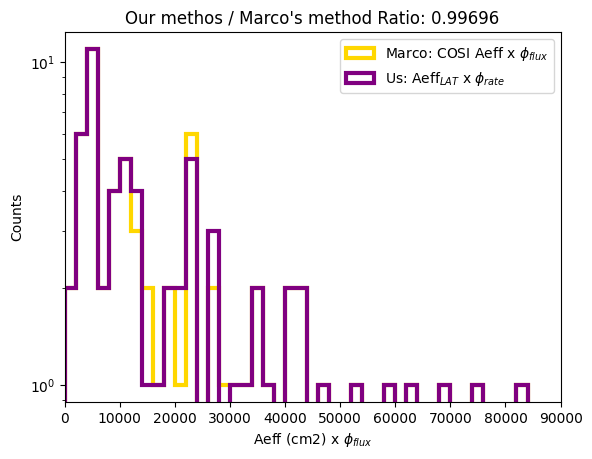

In [46]:
Aeffs_factors_f = 'figs/COSI_factors_all_updated_only_logpar_flare_updated_60deg_offaxis_last.csv'
Aeffs_factors_df = pd.read_csv(Aeffs_factors_f)[-64:]

Aeff_COSI = Aeffs_factors_df['Aeff_mean_COSI(cm2)'].values
print(len(Aeff_COSI))
Aeff_LAT = Aeffs_factors_df['Aeff_mean_LAT(cm2)'].values
Rate_ratio = Aeffs_factors_df['ph/s_ratio'].values
Int_flux_ratio = Aeffs_factors_df['Int_flux_ratio'].values

# compare the distributions od Aeff_COSI and Aeff_LAT * Rate_ratio
plt.figure()
plt.hist(Aeff_COSI * Int_flux_ratio, label='Marco: COSI Aeff x $\phi_{flux}$', histtype='step', bins=50, lw=3, color='gold', range=(0, 1e5))
plt.hist(Aeff_LAT * Rate_ratio, label='Us: Aeff$_{LAT}$ x $\phi_{rate}$', histtype='step', bins=50, color='purple', lw=3, range=(0, 1e5))
plt.title('Our methos / Marco\'s method Ratio: %.5f'%(np.mean(Aeff_LAT * Rate_ratio) / np.mean(Aeff_COSI * Int_flux_ratio)))
plt.xlabel('Aeff (cm2) x $\phi_{flux}$')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.xlim(0, 9e4)
# plt.xscale('log')
# compute average Aeffs
avg_Aeff_COSI = np.mean(Int_flux_ratio * Aeff_COSI)
avg_Aeff_LAT = np.mean(Aeff_LAT * Rate_ratio )
print('Average Aeff COSI:', avg_Aeff_COSI)
print('Average Aeff LAT * Rate ratio:', avg_Aeff_LAT)


# COSI MDP table

In [126]:
bkg_ = [20, 20, 20, 20, 20, 20,  1, 1, 1,1,1,1,]
eta_ = [0.1,0.3,0.5, 0.1,0.3,0.5, 0.1,0.3,0.5, 0.1,0.3,0.5,] #
softer_ = [False, False, False, True, True, True, False, False, False, True, True, True] 

f_ = [
      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.1_bkg20.00.csv',
      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.3_bkg20.00.csv',
      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.5_bkg20.00.csv',

      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.1_bkg20.00softer0.5.csv',
      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.3_bkg20.00softer0.5.csv',
      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.5_bkg20.00softer0.5.csv',

      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.1_bkg1.00.csv',
      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.3_bkg1.00.csv',
      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.5_bkg1.00.csv',

      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.1_bkg1.00softer0.5.csv',
      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.3_bkg1.00softer0.5.csv',
      '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.5_bkg1.00softer0.5.csv'
      ]

In [127]:
# build a function to print a txt file with the following structure:
def write_mdp_summary_txt(bkg_list, eta_list, softer_list, n_below_mdp50, n_below_mdp20, nsrc_below_mdp50, nsrc_below_mdp20, output_f='COSI_MDP_summary.txt'):
    with open(output_f, 'w') as f:
        f.write('Bkg_rate,$\gamma_1$,$\eta$,Num_flares_MDP50,Num_flares_MDP20,Num_sources_MDP50,Num_sources_MDP20\n')
        for i in range(len(bkg_list)):
            bkg_val = bkg_list[i]
            eta_val = eta_list[i]
            softer_val = softer_list[i]
            
            if bkg_val == 20:
                bkg_val_str = '(Baseline)'
            elif bkg_val == 1:
                bkg_val_str = '(Bestcase)'
            else:
                bkg_val_str = ''
            if softer_val:
                softer_val_str = '+0.5 softer'
            else:
                softer_val_str = '(Baseline)'
            print('Writing line for Bkg:', bkg_val, 'Eta:', eta_val, 'Softer:', softer_val_str)
            f.write(f'{bkg_val} Hz {bkg_val_str},{softer_val_str},{eta_val},{n_below_mdp50[i]},{n_below_mdp20[i]},{nsrc_below_mdp50[i]},{nsrc_below_mdp20[i]}\n')
    print(f'MDP summary written to {output_f}')

In [128]:
lowest_fluences_mdp50 = []
lowest_fluences_mdp20 = []
n_below_mdp50 = []
nsrc_below_mdp50 = []
n_below_mdp20 = []
nsrc_below_mdp20 = []
for i, f in enumerate(f_):
    print('----------------------------------')
    print('Bkg:', bkg_[i], 'cts/s')
    print('Eta:', eta_[i])
    print('Softer:', softer_[i])
    print('----------------------------------')
    print('File:', f)
    df2 = pd.read_csv(f, sep=',', index_col=False, header=0)

    #clean the dataframe: only durations <8 weeks
    df2 = df2[df2['Duration_(s)'] <= 8*7*24*60*60]
    print('Number of flares with duration <=8 weeks:', len(df2))
    
    #create 2 df one for only BLL and one for FSRQ
    df2_bll = df2[df2['Class'] == 'BLL']
    df2_fsrq = df2[df2['Class'] == 'FSRQ']
    df2_bcu = df2[df2['Class'] == 'BCU']
    #check num of sources below MDP=0.5
    print('Number of sources below MDP=0.5:', len(df2[df2['MDP99_(%)'] < 50]))
    print('From unique sources:', len(df2[df2['MDP99_(%)'] < 50]['Name'].unique()))
    print('Lowest fluence:', np.min(df2[df2['MDP99_(%)'] < 50]['Photon_Fluence_(ph/cm2)_(0.2-5_MeV)']), 'ph/cm2')
    lowest_fluences_mdp50.append(np.min(df2[df2['MDP99_(%)'] < 50]['Photon_Fluence_(ph/cm2)_(0.2-5_MeV)']))
    n_below_mdp50.append(len(df2[df2['MDP99_(%)'] < 50]))
    # check unique sources below MDP=0.5
    print('Unique sources below MDP=0.5:', len(df2[df2['MDP99_(%)'] < 50]['Name'].unique()))
    nsrc_below_mdp50.append(len(df2[df2['MDP99_(%)'] < 50]['Name'].unique()))
    #check num of sources below MDP=0.3
    print('Number of sources below MDP=0.3:', len(df2[df2['MDP99_(%)'] < 20]))
    print('From unique sources:', len(df2[df2['MDP99_(%)'] < 20]['Name'].unique()))
    print('Lowest fluence:', np.min(df2[df2['MDP99_(%)'] < 20]['Photon_Fluence_(ph/cm2)_(0.2-5_MeV)']), 'ph/cm2')
    n_below_mdp20.append(len(df2[df2['MDP99_(%)'] < 20]))
    # check unique sources below MDP=0.2
    print('Unique sources below MDP=0.2:', len(df2[df2['MDP99_(%)'] < 20]['Name'].unique()))
    nsrc_below_mdp20.append(len(df2[df2['MDP99_(%)'] < 20]['Name'].unique()))
    lowest_fluences_mdp20.append(np.min(df2[df2['MDP99_(%)'] < 20]['Photon_Fluence_(ph/cm2)_(0.2-5_MeV)']))
    #how many sources in each df
    print('Number of flares from BLL:', len(df2_bll), 'from unique sources:', len(df2_bll['Name'].unique()))
    print('Number of flares from FSRQ:', len(df2_fsrq), 'from unique sources:', len(df2_fsrq['Name'].unique()))
    print('Number of flares from BCU:', len(df2_bcu), 'from unique sources:', len(df2_bcu['Name'].unique()))
    print()

txt_file_output = '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/COSI_MDP_summary_Nov2025.txt'
write_mdp_summary_txt(bkg_, eta_, softer_, n_below_mdp50, n_below_mdp20, nsrc_below_mdp50, nsrc_below_mdp20, output_f=txt_file_output)

----------------------------------
Bkg: 20 cts/s
Eta: 0.1
Softer: False
----------------------------------
File: /Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.1_bkg20.00.csv
Number of flares with duration <=8 weeks: 1166
Number of sources below MDP=0.5: 0
From unique sources: 0
Lowest fluence: nan ph/cm2
Unique sources below MDP=0.5: 0
Number of sources below MDP=0.3: 0
From unique sources: 0
Lowest fluence: nan ph/cm2
Unique sources below MDP=0.2: 0
Number of flares from BLL: 137 from unique sources: 52
Number of flares from FSRQ: 437 from unique sources: 125
Number of flares from BCU: 45 from unique sources: 26

----------------------------------
Bkg: 20 cts/s
Eta: 0.3
Softer: False
----------------------------------
File: /Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.3_bkg20.00.csv
Number of flares with duration <=8 weeks: 2018
Number of sources below MDP=0.5: 0
From unique sources: 0
Lowest fluence: nan ph/cm2
Unique sou

In [129]:

# Name of your txt file (comma-separated)
df = pd.read_csv(txt_file_output)

# --- 2. Optional pretty label maps to control LaTeX output ---
# Format the flare+source output
def format_flares(n_flares, n_sources):
    if n_flares == 0:
        return "0"
    return f"{n_flares} (from {n_sources} sources)"

# Order of background rates and gamma values
bkg_order = list(df["Bkg_rate"].unique())          # ['20 Hz (Baseline)', '1 Hz (Bestcase)']
gamma_order = list(df["$\\gamma_1$"].unique())     # ['(Baseline)', '+0.5 softer']

bkg_label_map = {
    "20 Hz (Baseline)": r"20 Hz (Baseline)",
    "1 Hz (Bestcase)":  r"1 Hz (Best case)",  # small pretty-print tweak
}

gamma_label_map = {
    "(Baseline)":   r"Baseline",
    "+0.5 softer":  r"+0.5 Softer",
}

# --- 3. Build the LaTeX table ---

lines = []

lines.append(r"\begin{table}")
lines.append(r"    %\centering")
lines.append(r"    \begin{tabular}{c c|c|c|c}")
lines.append(
    r"       Bkg rate [Hz]  & $\gamma_1$ & $\eta$ & Num. flares $<$MDP$_{99\%}$=50\% & Num. flares $<$MDP$_{99\%}$=20\%\\"
)
lines.append(r"    \hline")

for ib, bkg in enumerate(bkg_order):
    sub_bkg = df[df["Bkg_rate"] == bkg]
    if sub_bkg.empty:
        continue

    n_bkg = len(sub_bkg)
    bkg_label = bkg_label_map.get(bkg, bkg)

    for ig, gamma in enumerate(gamma_order):
        sub_gamma = sub_bkg[sub_bkg["$\\gamma_1$"] == gamma]
        if sub_gamma.empty:
            continue

        n_gamma = len(sub_gamma)
        gamma_label = gamma_label_map.get(gamma, gamma)

        for ir, (_, row) in enumerate(sub_gamma.iterrows()):
            cells = []

            # First column: Bkg_rate multirow for first row of first gamma block
            if ig == 0 and ir == 0:
                cells.append(r"\multirow{%d}{*}{%s}" % (n_bkg, bkg_label))
            else:
                cells.append("")

            # Second column: gamma_1 multirow for first row in this gamma subgroup
            if ir == 0:
                cells.append(r"\multirow{%d}{*}{%s}" % (n_gamma, gamma_label))
            else:
                cells.append("")

            # η formatting: convert 0.1 -> 10\%, etc.
            eta_val = row["$\\eta$"]
            try:
                eta_num = float(eta_val)
                if 0.0 < eta_num <= 1.0:
                    eta_str = f"{int(eta_num * 100)}\\%"
                else:
                    eta_str = str(eta_val)
            except Exception:
                eta_str = str(eta_val)

            f50 = format_flares(row["Num_flares_MDP50"], row["Num_sources_MDP50"])
            f20 = format_flares(row["Num_flares_MDP20"], row["Num_sources_MDP20"])


            cells.extend([eta_str, f50, f20])

            line = "                        " + " & ".join(cells) + r" \\"
            lines.append(line)

        # After finishing first gamma block in this background, add \cline{2-5}
        if ig == 0:
            lines.append(r"    \cline{2-5}")

    # After each background block, add \hline
    lines.append(r"    \hline")

lines.append(r"    \end{tabular}")
lines.append(
    r"    \caption{Number of flares in our LCR selected sample identified to provide an MDP$_{99\%}$ in the COSI band below 50\% and 20\%. We report the results for combinations of $\eta$ and $\gamma_1$ and background rates, and the resulting number of detected flares with MDP$_{99\%}<50\%$ and $<20\%$.}"
)
lines.append(r"    \label{tab:flare_mdp_summary}")
lines.append(r"\end{table}")

latex_table = "\n".join(lines)
print(latex_table)

\begin{table}
    %\centering
    \begin{tabular}{c c|c|c|c}
       Bkg rate [Hz]  & $\gamma_1$ & $\eta$ & Num. flares $<$MDP$_{99\%}$=50\% & Num. flares $<$MDP$_{99\%}$=20\%\\
    \hline
                        \multirow{6}{*}{20 Hz (Baseline)} & \multirow{3}{*}{Baseline} & 10\% & 0 & 0 \\
                         &  & 30\% & 0 & 0 \\
                         &  & 50\% & 1 (from 1 sources) & 0 \\
    \cline{2-5}
                         & \multirow{3}{*}{+0.5 Softer} & 10\% & 5 (from 1 sources) & 0 \\
                         &  & 30\% & 18 (from 3 sources) & 0 \\
                         &  & 50\% & 24 (from 4 sources) & 1 (from 1 sources) \\
    \hline
                        \multirow{6}{*}{1 Hz (Best case)} & \multirow{3}{*}{Baseline} & 10\% & 13 (from 2 sources) & 0 \\
                         &  & 30\% & 33 (from 5 sources) & 1 (from 1 sources) \\
                         &  & 50\% & 46 (from 10 sources) & 3 (from 2 sources) \\
    \cline{2-5}
                         & \multiro

# COSI MDP plots

In [197]:
# wrap the code below in a function to plot the MDP colormap for FSRQ only given a dataframe df2_clean
def plot_mdp_colormap_fsrq(dataframe, plot_eta_value, plot_bkg_value, save_fig=False, fig_name='mdp_colormap_fsrq.png'):
    ############
    # FSRQ only
    ############

    CMAP = 'cubehelix_r'
    
    # f = '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/Aug2025_COSI_eta0.5_bkg0.10_Softer+0.5.csv'
    # df2 = pd.read_csv(f, sep=',', index_col=False, header=0)
    fsrq = dataframe[dataframe['Class'] == 'FSRQ']
    # consider only MDP<=100
    fsrq = fsrq[fsrq['MDP99_(%)'] <= 100]
    #consider only durations <8 weeks
    fsrq = fsrq[fsrq['Duration_(s)'] <= 8*7*24*60*60]
    print('Number of FSRQ flares with MDP<=100 and duration <=8 weeks:', len(fsrq))
    dur = fsrq['Duration_(s)']/60/60/24/7  # convert to weeks

    # print the nuique values of durations
    print('Unique durations (weeks):', np.unique(dur))
    dmin, dmax = dur.min(), dur.max()
    fmin, fmax = fsrq['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].min(), fsrq['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].max()
    print('Duration range (weeks):', dmin, dmax)
    print('Flux range (ph/cm2/s):', fmin, fmax)

    #count how many flares below 50% MDP
    n_below_mdp50 = len(fsrq[fsrq['MDP99_(%)'] < 50])
    print('Number of FSRQ flares below MDP=50%:', n_below_mdp50)
    # count how many flares below 20% MDP
    n_below_mdp20 = len(fsrq[fsrq['MDP99_(%)'] < 20])   
    print('Number of FSRQ flares below MDP=20%:', n_below_mdp20)

    # scale the duration values into a reasonable marker size range
    sizes = 50 + 800 * (dur - dur.min()) / (dur.max() - dur.min())


    #print lowest MDP in the sample
    print('Lowest MDP in the sample:', np.min(dataframe['MDP99_(%)']))
    # to what duration and flux corresponds?
    idx_min_mdp = np.argmin(dataframe['MDP99_(%)'])
    print('Duration (weeks):', dataframe['Duration_(s)'].values[idx_min_mdp]/60/60/24/7)
    print('Flux (ph/cm2/s):', dataframe['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].values[idx_min_mdp])


    # data
    x = fsrq['Duration_(s)'].to_numpy() /60/60/24/7
    y = fsrq['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].to_numpy()
    z = fsrq['MDP99_(%)'].to_numpy()

    # log-spaced grid that matches your log axes
    nx, ny = 300, 300
    # dmin, dmax = x.min(), x.max()
    # fmin, fmax = y.min(), y.max()
    gx = np.logspace(np.log10(dmin), np.log10(10), nx)
    gy = np.logspace(np.log10(fmin-0.2*fmin), np.log10(fmax+0.2*fmax), ny)
    GX, GY = np.meshgrid(gx, gy, indexing='xy')  # GX.shape == GY.shape == (ny, nx)

    # ---- interpolation (example: smoothed spline in log–log space) ----
    xu, yu = np.log10(x), np.log10(y)
    s = 1.0 * len(z) * np.var(z)                 # tune smoothing as needed
    spline = SmoothBivariateSpline(xu, yu, z, s=s, kx=3, ky=3)

    # Evaluate on grid; keep shape (ny, nx)
    Z = spline.ev(np.log10(GX).ravel(), np.log10(GY).ravel()).reshape(GX.shape)

    # ---- plot without transposes ----
    fig, ax = plt.subplots(figsize=(8,6))
    pcm = ax.pcolormesh(GX, GY, Z, shading='auto', cmap=CMAP, vmin=0, vmax=100, alpha=0.7)
    plt.scatter(
        fsrq['Duration_(s)']/60/60/24/7,
        fsrq['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'],
        c=fsrq['MDP99_(%)'],
        cmap=CMAP,
        marker='o',
        s=sizes,            # size varies with duration
        alpha=0.8,
        edgecolor='k',
    )

    # scattter of th epoint with MDP>50% with black filled color but 0.5 alpha
    fsrq_above50 = fsrq[fsrq['MDP99_(%)'] >= 50]
    #no fill color but hatched edge
    plt.scatter(
        fsrq_above50['Duration_(s)']/60/60/24/7,
        fsrq_above50['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'],
        facecolors='none',
        edgecolors='k',
        hatch='///',
        c='none',
        marker='o',
        s=sizes[fsrq['MDP99_(%)'] >= 50],            # size varies with duration
        alpha=0.5,
        edgecolor='k',
    )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1.8, 8.5)
    ax.set_ylim(gy.min(), gy.max())
    ax.set_xlabel('Flare Duration (weeks)', size=15)
    ax.set_ylabel('0.2–5 MeV Photon Flux (ph/cm²/s)', size=15)
    ax.set_title(r'$\eta=%.1f$, $R_{bkg}=%.1f$ ph/s' % (plot_eta_value, plot_bkg_value), size=15)

    #change format of x-axis tick labels to 1,2,3...
    from matplotlib.ticker import FormatStrFormatter
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    
    # make label of colorbar
    cbar = plt.colorbar(label=r'$MDP_{99}$')
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.yaxis.label.set_size(15)
    cbar.ax.xaxis.label.set_size(15)
    #add a line at the MDP=50% and MDP=20%
    cs = ax.contour(GX, GY, Z, levels=[20, 50], colors=['0.5', 'black'], linestyles=['--', '--'], linewidths=2)
    # add labels to the contour lines
    fmt = {50: 'MDP=50%', 20: 'MDP=20%'}
    ax.clabel(cs, inline=True, fontsize=11, fmt=fmt)
    plt.tight_layout()
    # plt.savefig(title_fig, dpi=200)


    if save_fig:
        plt.savefig(fig_name, dpi=200)

def plot_cumulative_fluence_flare_count(dataframe, plot_eta, plot_bkg, save_fig=False, fig_name='cumulative_fluence_flare_count.png'):
    print('Total number of sources in the sample:', len(dataframe))
    bll = dataframe[dataframe['Class'] == 'BLL']
    fsrq = dataframe[dataframe['Class'] == 'FSRQ']
    bcu = dataframe[dataframe['Class'] == 'BCU']
    bll_tot = len(bll)
    fsrq_tot = len(fsrq)
    bcu_tot = len(bcu)
    print('Total number of flares from BCU in the sample:', bcu_tot)
    print('from unique sources:', len(bcu['Name'].unique()))
    print('Total number of flares from BLL in the sample:', bll_tot)
    print('from unique sources:', len(bll['Name'].unique()))    
    print('Total number of flares from FSRQ in the sample:', fsrq_tot)
    print('from unique sources:', len(fsrq['Name'].unique()))

    fluence_th_array = np.logspace(np.log10(1e-3), np.log10(1e5), 1000)
    bll_flares_above_th = []
    fsrq_flares_above_th = []
    bcu_flares_above_th = []
    for th in fluence_th_array:
        bll_flares_above_th.append(len(bll[bll['Photon_Fluence_(ph/cm2)_(0.2-5_MeV)'] > th]))
        fsrq_flares_above_th.append(len(fsrq[fsrq['Photon_Fluence_(ph/cm2)_(0.2-5_MeV)'] > th]))
        bcu_flares_above_th.append(len(bcu[bcu['Photon_Fluence_(ph/cm2)_(0.2-5_MeV)'] > th]))
    bll_flares_above_th = np.array(bll_flares_above_th)
    fsrq_flares_above_th = np.array(fsrq_flares_above_th)
    bcu_flares_above_th = np.array(bcu_flares_above_th)
    #figure of the 1/cumulative of the fluence for BLL, FSRQ and BCU


    plt.figure(figsize=(8,6))
    plt.title(r'Flares above a given fluence threshold ($\eta$={}, Bkg={})'.format(plot_eta, plot_bkg), size=15)
    plt.step(fluence_th_array, bll_flares_above_th/17, where='post', label='BLL', color='blue', linewidth=4)
    plt.step(fluence_th_array, fsrq_flares_above_th/17, where='post', label='FSRQ', color='red', linewidth=4)
    plt.step(fluence_th_array, bcu_flares_above_th/17, where='post', label='BCU', color='0.6', linewidth=4, linestyle='--')
    # mark 1 flare per year
    plt.hlines(1, fluence_th_array[0], fluence_th_array[-1], linestyle='--', color='silver')
    plt.annotate('1 flare per year', xy=(fluence_th_array[10], 1.1), color='silver', size=12)

    #Show the lowest fluence for MDP=0.5 and MDP=0.3
    for i, th in enumerate(lowest_fluences_mdp50):
        bkg = bkg_[i]
        if bkg == 1.00:
            continue
        eta = eta_[i]
        if eta != 0.5:
            continue
        softer = softer_[i]
        print(bkg, softer, th)
        if softer:
            print('Softer spectrum case')
            plt.vlines(th, 0.06, 220, linestyle=':', color='0.5')
            print('min fluence for MDP<50% (softer)', th)
            plt.vlines(lowest_fluences_mdp20[i], 0.06, 220, linestyle='-.', color='0.5')
            print('min fluence for MDP<20% (softer)', lowest_fluences_mdp20[i])
            #Bkg=%.2f - $\eta$=%.1f - Softer'%(bkg, eta)
            plt.annotate('Min fluence for MDP<50%',
                    xy=(th*1.1, 8), color='0.5', size=10, rotation=90)
            plt.annotate('Min fluence for MDP<20%',
                    xy=(lowest_fluences_mdp20[i]*1.1, 8), color='0.5', size=10, rotation=90)
        else:
            print('Standard spectrum case')
            continue
            # plt.annotate('Bkg=%.2f - $\eta$=%.1f'%(bkg, eta), 
            #          xy=(th*1.1, 15), color='0.5', size=10, rotation=90)
    # plt.step(np.sort(df2_bcu['Fluence (ph/cm2)']), np.cumsum(bcu['Fluence (ph/cm2)'])[::-1], where='post', label='BCU', color='0.6')
    plt.xscale('log')
    plt.yscale('log')  
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.ylim(0.06, 220)
    plt.xlabel(r'0.2–5 MeV Fluence (ph/cm$^2$)', size=15)    
    plt.ylabel(r'N$_{flares}$(>Fluence)/year', size=15) 
    plt.legend(fontsize=12, loc=3)

    if save_fig:
        plt.savefig(fig_name, dpi=200)

<!-- Index(['Unnamed: 0', 'Name', 'Class', 'Photon Flux (ph/cm2/s)',
       'Fluence (ph/cm2)', 'Photon Count', 'Background Counts', 'Duration (s)',
       'Duration (weeks)', 'Fraction of Observation Time', 'MDP99',
       'Start Time (MJD)', 'Start Time (s)', 'Asymmetry'],
      dtype='object') -->

In [205]:
#select the plot case:

f = '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/November2025_COSI_Eta0.3_bkg1.00.csv'
plot_eta = 0.3
plot_bkg = 1.0

df2 = pd.read_csv(f, sep=',', index_col=False, header=0)

# remove rows that have nan or -3333 in any of the relevant columns
relevant_columns = ['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)',  'Photon_Fluence_(ph/cm2)_(0.2-5_MeV)', 'MDP99_(%)']
df2_clean = df2.dropna(subset=relevant_columns)
for col in relevant_columns:
    df2_clean = df2_clean[df2_clean[col] != -3333]  
print('After cleaning, number of flares:', len(df2_clean))  

#how many unique sources in the cleaned dataframe
print('Number of unique sources in the cleaned dataframe:', len(df2_clean['Name'].unique()))

After cleaning, number of flares: 4206
Number of unique sources in the cleaned dataframe: 710


Total number of sources in the sample: 4206
Total number of flares from BCU in the sample: 316
from unique sources: 115
Total number of flares from BLL in the sample: 1202
from unique sources: 205
Total number of flares from FSRQ in the sample: 2302
from unique sources: 356
20 False 12685.265008589216
Standard spectrum case
20 True 5445.554602521157
Softer spectrum case
min fluence for MDP<50% (softer) 5445.554602521157
min fluence for MDP<20% (softer) 27152.41939725724
Number of FSRQ flares with MDP<=100 and duration <=8 weeks: 74
Unique durations (weeks): [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  7.  7.5 8. ]
Duration range (weeks): 1.0 8.0
Flux range (ph/cm2/s): 0.0002643119114898 0.0027393596294628
Number of FSRQ flares below MDP=50%: 33
Number of FSRQ flares below MDP=20%: 1
Lowest MDP in the sample: 1.5303984680464462
Duration (weeks): 231.5
Flux (ph/cm2/s): 0.0031527309118617


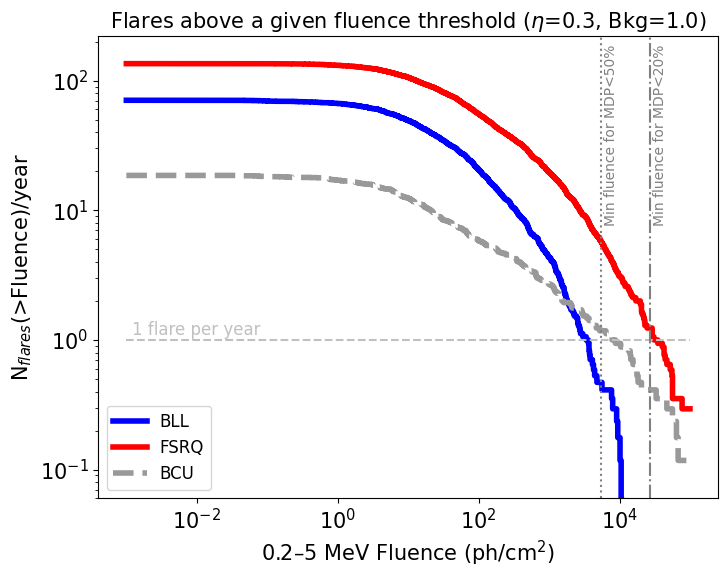

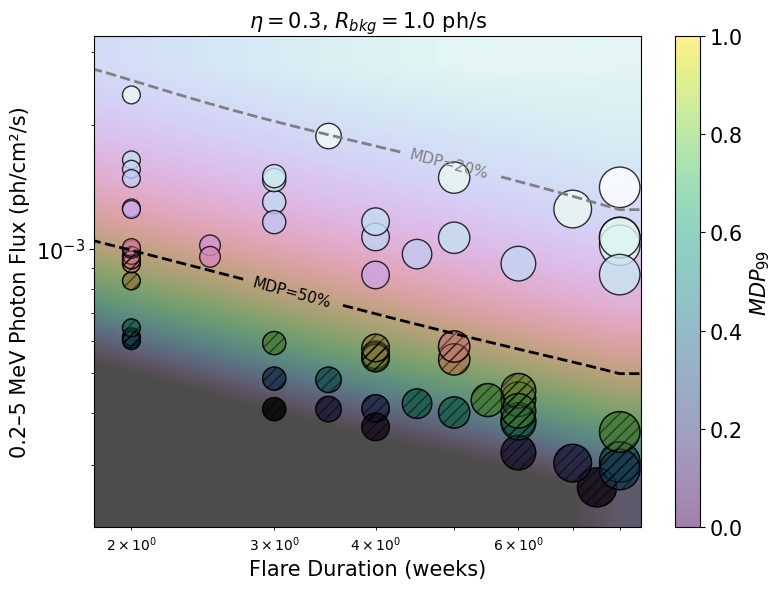

In [199]:
plot_cumulative_fluence_flare_count(df2_clean, plot_eta, plot_bkg, save_fig=True, fig_name='/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/Cumulative_fluence_flare_count_eta{}_bkg{}.png'.format(plot_eta, plot_bkg))

plot_mdp_colormap_fsrq(df2_clean, 0.3, 1.0, save_fig=True, fig_name='/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/mdp_colormap_fsrq_eta{}_bkg{}.png'.format(plot_eta, plot_bkg))


# Duty cycle from original csv

In [3]:
#select the plot case:

f = '/home/lkoo/projects/LCRanalyses/RemadeNov2025/November2025_COSI_Eta0.3_bkg1.00.csv'
plot_eta = 0.3
plot_bkg = 1.0

df2 = pd.read_csv(f, sep=',', index_col=False, header=0)

# remove rows that have nan or -3333 in any of the relevant columns
relevant_columns = ['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)',  'Photon_Fluence_(ph/cm2)_(0.2-5_MeV)', 'MDP99_(%)']
df2_clean = df2.dropna(subset=relevant_columns)
for col in relevant_columns:
    df2_clean = df2_clean[df2_clean[col] != -3333]  
print('After cleaning, number of flares:', len(df2_clean))  

# print how many unique sources are in the cleaned dataframe, hoe many BLL, FSRQ, BCU
print('Unique sources in cleaned dataframe:', len(df2_clean['Name'].unique()))
print('Unique BLL sources:', len(df2_clean[df2_clean['Class']=='BLL']['Name'].unique()))
print('Unique FSRQ sources:', len(df2_clean[df2_clean['Class']=='FSRQ']['Name'].unique()))
print('Unique BCU sources:', len(df2_clean[df2_clean['Class']=='BCU']['Name'].unique()))

After cleaning, number of flares: 4207
Unique sources in cleaned dataframe: 710
Unique BLL sources: 205
Unique FSRQ sources: 356
Unique BCU sources: 115


Max flux BLL: 0.0003183555362527
Max flux FSRQ: 0.0027393596294628
Max flux BCU: 0.0031527309118617
Number of sources with unknown class: 34


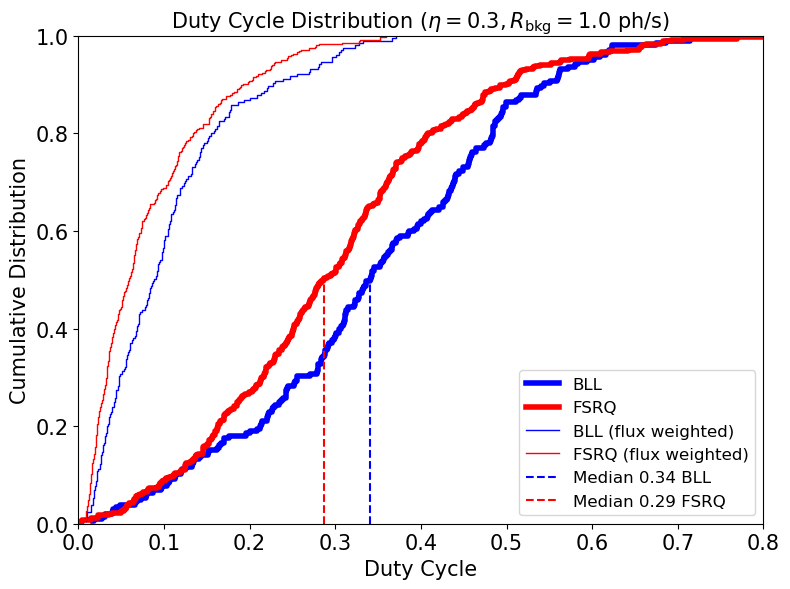

In [20]:
unique_names = df2_clean['Name'].unique()
source_classes = []
for n in unique_names:
    df_n = df2_clean[df2_clean['Name'] == n]
    source_classes.append(df_n['Class'].values[0])
source_classes = np.array(source_classes)

duty_cycles = []
for n in unique_names:
    df_n = df2_clean[df2_clean['Name'] == n]
    total_time = np.sum(df_n['Duration_(s)'])
    duty_cycle = total_time / (17*365*24*60*60)  # 17 years of observation
    duty_cycles.append(duty_cycle)
duty_cycles = np.array(duty_cycles)

# fluence factor based on the mean fluence of all sources
flux_factors_bll = df2_clean['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].values/np.max(df2_clean[df2_clean['Class'] == 'BLL']['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].values)
print('Max flux BLL:', np.max(df2_clean[df2_clean['Class'] == 'BLL']['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].values))
print('Max flux FSRQ:', np.max(df2_clean[df2_clean['Class'] == 'FSRQ']['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].values))
print('Max flux BCU:', np.max(df2_clean[df2_clean['Class'] == 'BCU']['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].values))
flux_factors_fsrq = df2_clean['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].values/np.max(df2_clean[df2_clean['Class'] == 'FSRQ']['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].values)
flux_factors_bcu = df2_clean['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].values/np.max(df2_clean[df2_clean['Class'] == 'BCU']['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'].values)
# add column to df2 with the flux factor
df2_clean['Flux factor BLL'] = flux_factors_bll
df2_clean['Flux factor FSRQ'] = flux_factors_fsrq
df2_clean['Flux factor BCU'] = flux_factors_bcu
flux_weighted_duty_cycles = []
unknown_classes = 0
for n in unique_names:
    df_n = df2_clean[df2_clean['Name'] == n]
    if df_n['Class'].values[0] == 'BLL':
        total_time = np.sum(df_n['Duration_(s)'] * df_n['Flux factor BLL'])/np.sum(df_n['Flux factor BLL'])
    elif df_n['Class'].values[0] == 'FSRQ':
        total_time = np.sum(df_n['Duration_(s)'] * df_n['Flux factor FSRQ'])/np.sum(df_n['Flux factor FSRQ'])
    elif df_n['Class'].values[0] == 'BCU':
        total_time = np.sum(df_n['Duration_(s)'] * df_n['Flux factor BCU'])/np.sum(df_n['Flux factor BCU'])
    else:
        total_time = np.sum(df_n['Duration_(s)'] * df_n['Flux factor BCU'])/np.sum(df_n['Flux factor BCU'])
        unknown_classes += 1
    # compute the flux weighted duty cycle
    
    # df_n['w'] = df_n['Photon Flux (ph/cm2/s)']
    # total_w = df_n['w'].sum()
    # total_time = np.sum(df_n['Duration (s)'] * df_n['w'])/np.sum(df_n['w'])
    flux_weighted_duty_cycle = total_time / (17*365*24*60*60)  # 17 years of observation
    flux_weighted_duty_cycles.append(flux_weighted_duty_cycle)
flux_weighted_duty_cycles = np.array(flux_weighted_duty_cycles)


print('Number of sources with unknown class:', unknown_classes)


# plot the duty cycle cumulative distributions fro BLL and FSRQ
plt.figure(figsize=(8,6))
plt.title(r'Duty cycle distribution ($\eta$={}, Bkg={})'.format(plot_eta, plot_bkg), size=15)
iii_bll = np.where(source_classes == 'BLL')[0]
iii_fsrq = np.where(source_classes == 'FSRQ')[0]
iii_both = np.where((source_classes == 'FSRQ') | (source_classes == 'BLL'))
plt.step(np.sort(duty_cycles[iii_bll]), np.arange(1, len(duty_cycles[iii_bll])+1)/len(duty_cycles[iii_bll]), where='post', label='BLL', color='blue', linewidth=4)
plt.step(np.sort(duty_cycles[iii_fsrq]), np.arange(1, len(duty_cycles[iii_fsrq])+1)/len(duty_cycles[iii_fsrq]), where='post', label='FSRQ', color='red', linewidth=4)
#plt.step(np.sort(duty_cycles[iii_both]), np.arange(1, len(duty_cycles[iii_both])+1)/len(duty_cycles[iii_both]), where='post', label='BL Lac + FSRQ', color='k', linewidth=4)
plt.step(np.sort(flux_weighted_duty_cycles[iii_bll]), np.arange(1, len(flux_weighted_duty_cycles[iii_bll])+1)/len(flux_weighted_duty_cycles[iii_bll]), where='post', label='BLL (flux weighted)', color='blue', linewidth=1)
plt.step(np.sort(flux_weighted_duty_cycles[iii_fsrq]), np.arange(1, len(flux_weighted_duty_cycles[iii_fsrq])+1)/len(flux_weighted_duty_cycles[iii_fsrq]), where='post', label='FSRQ (flux weighted)', color='red', linewidth=1)
#plt.step(np.sort(flux_weighted_duty_cycles[iii_both]), np.arange(1, len(flux_weighted_duty_cycles[iii_both])+1)/len(flux_weighted_duty_cycles[iii_both]), where='post', label='BL Lac + FSRQ (flux weighted)', color='k', linewidth=1)
# mark the median duty cycle for bll and fsrq
plt.vlines(np.sort(duty_cycles[iii_bll])[int(len(duty_cycles[iii_bll])/2)], 0, 0.5, linestyle='--', color='blue', label=f'Median {np.sort(duty_cycles[iii_bll])[int(len(duty_cycles[iii_bll])/2)]:.2f} BLL')
plt.vlines(np.sort(duty_cycles[iii_fsrq])[int(len(duty_cycles[iii_fsrq])/2)], 0, 0.5, linestyle='--', color='red', label=f'Median {np.sort(duty_cycles[iii_fsrq])[int(len(duty_cycles[iii_fsrq])/2)]:.2f} FSRQ')
#plt.vlines(np.sort(duty_cycles[iii_both])[int(len(duty_cycles[iii_both])/2)], 0, 0.5, linestyle='--', color='k', label=f'Median {np.sort(duty_cycles[iii_both])[int(len(duty_cycles[iii_both])/2)]:.2f} BL Lac + FSRQ')

#plt.hlines(0.5, 0, np.sort(duty_cycles[iii_bll])[int(len(duty_cycles[iii_bll])/2)], linestyle='--', color='silver', label =f'Median {np.sort(duty_cycles[iii_both])[int(len(duty_cycles[iii_both])/2)]:.2f} BL Lac + FSRQ')

# plt.ylim(0.06, 1.1)
# plt.xlabel(r'Duty cycle', size=15)    
# plt.ylabel(r'N$_{sources}$(<Duty cycle)/N$_{total}$', size=15) 
plt.legend(fontsize=12, loc=4)  
 
plt.xlabel('Duty Cycle', size=15)
plt.ylabel('Cumulative Distribution', size=15)
# put a space between ph/s and the number in the title below.
plt.title(r'Duty Cycle Distribution ($\eta={}, R_\mathrm{{bkg}}={} \ \mathrm{{ph/s}}$)'.format(plot_eta, plot_bkg), size=15)
plt.xlim(0, 0.8)
plt.ylim(0, 1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.tight_layout()
# this figure shows the CDF of the duty cycle for bll and fsrq for eta=0.5.
# plt.savefig('/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/DutyCycle_CDF_Rbkg{}_Eta{}.png'.format(plot_bkg, plot_eta), dpi=200)

In [203]:
# get a spline of the cumulative distribution
dc_5_fsrq_sorted = np.sort(duty_cycles[iii_fsrq])
dc_5_bll_sorted = np.sort(duty_cycles[iii_bll])
dc_5_bll_cdf = np.arange(1, len(dc_5_bll_sorted)+1) / len(dc_5_bll_sorted)
dc_5_fsrq_cdf = np.arange(1, len(dc_5_fsrq_sorted)+1) / len(dc_5_fsrq_sorted)    

dc_bll_spline = interp1d(dc_5_bll_sorted, dc_5_bll_cdf, kind='linear', fill_value='extrapolate')
dc_fsrq_spline = interp1d(dc_5_fsrq_sorted, dc_5_fsrq_cdf, kind='linear', fill_value='extrapolate') 
dc_ = np.linspace(0, 1, 1000)

#compute the max deviation between the two cumulative distributions
D = np.max(np.abs(dc_bll_spline(dc_) - dc_fsrq_spline(dc_)))
print('Max deviation between BLL and FSRQ cumulative distributions:', D)

m = len(dc_5_bll_sorted) 
n = len(dc_5_fsrq_sorted)
# factor = np.sqrt((len(dc_bll_sorted) + len(dc_fsrq_sorted)) / (len(dc_bll_sorted) * len(dc_fsrq_sorted)))
alpha_5sigma = 0.0000003 #5sigma
alpha_4sigma = 0.000063 #4sigma
alpha_3sigma = 0.003 #3sigma
alpha_2sigma = 0.05 #2sigma
D_alpha_2sigma = np.sqrt(-np.log(alpha_2sigma/2) / (1+(m/n))/(2*m))
print('D_alpha for alpha=0.05:', D_alpha_2sigma)
D_alpha_3sigma = np.sqrt(-np.log(alpha_3sigma/2) / (1+(m/n))/(2*m))
print('D_alpha for alpha=0.003:', D_alpha_3sigma)
D_alpha_4sigma = np.sqrt(-np.log(alpha_4sigma/2) / (1+(m/n))/(2*m))
print('D_alpha for alpha=0.000063:', D_alpha_4sigma)
D_alpha_5sigma = np.sqrt(-np.log(alpha_5sigma/2) / (1+(m/n))/(2*m))
print('D_alpha for alpha=0.0000003:', D_alpha_5sigma)

#repeat the test on the weighted duty cycles
flux_weighted_duty_cycles_bll = flux_weighted_duty_cycles[iii_bll]
flux_weighted_duty_cycles_fsrq = flux_weighted_duty_cycles[iii_fsrq]
flux_weighted_duty_cycles_bll_sorted = np.sort(flux_weighted_duty_cycles_bll)
flux_weighted_duty_cycles_fsrq_sorted = np.sort(flux_weighted_duty_cycles_fsrq)
flux_weighted_duty_cycles_bll_cdf = np.arange(1, len(flux_weighted_duty_cycles_bll_sorted)+1) / len(flux_weighted_duty_cycles_bll_sorted)
flux_weighted_duty_cycles_fsrq_cdf = np.arange(1, len(flux_weighted_duty_cycles_fsrq_sorted)+1) / len(flux_weighted_duty_cycles_fsrq_sorted)    
flux_weighted_dc_bll_spline = interp1d(flux_weighted_duty_cycles_bll_sorted, flux_weighted_duty_cycles_bll_cdf, kind='linear', fill_value='extrapolate')
flux_weighted_dc_fsrq_spline = interp1d(flux_weighted_duty_cycles_fsrq_sorted, flux_weighted_duty_cycles_fsrq_cdf, kind='linear', fill_value='extrapolate') 
dc_fw_ = np.linspace(0, min(flux_weighted_duty_cycles_bll_sorted[-1], flux_weighted_duty_cycles_fsrq_sorted[-1]), 1000)
D_fw = np.max(np.abs(flux_weighted_dc_bll_spline(dc_fw_) - flux_weighted_dc_fsrq_spline(dc_fw_)))
print('Max deviation between BLL and FSRQ cumulative distributions (flux weighted):', D_fw)
m_fw = len(flux_weighted_duty_cycles_bll_sorted) 
n_fw = len(flux_weighted_duty_cycles_fsrq_sorted)
D_alpha_2sigma_fw = np.sqrt(-np.log(alpha_2sigma/2) / (1+(m_fw/n_fw))/(2*m_fw))
print('D_alpha for 2 sigma (alpha=0.05) (flux weighted):', D_alpha_2sigma_fw)
D_alpha_3sigma_fw = np.sqrt(-np.log(alpha_3sigma/2) / (1+(m_fw/n_fw))/(2*m_fw))
print('D_alpha for 3 sigma (alpha=0.003) (flux weighted):', D_alpha_3sigma_fw)
D_alpha_4sigma_fw = np.sqrt(-np.log(alpha_4sigma/2) / (1+(m_fw/n_fw))/(2*m_fw))
print('D_alpha for 4 sigma (alpha=0.000063) (flux weighted):', D_alpha_4sigma_fw)
D_alpha_5sigma_fw = np.sqrt(-np.log(alpha_5sigma/2) / (1+(m_fw/n_fw))/(2*m_fw))
print('D_alpha for 5 sigma (alpha=0.0000003) (flux weighted):', D_alpha_5sigma_fw)

# ΔDC=DC weighted −DC unweighted and compare median(ΔDC) (and its CI) between classes (e.g., Mann–Whitney U test). 
# If ∣ΔDC∣ is larger for BLLs, then you can state that weighting reduces their duty cycles more.
delta_dc_bll = np.abs(flux_weighted_duty_cycles_bll_sorted - np.sort(duty_cycles[iii_bll]))
delta_dc_fsrq = np.abs(flux_weighted_duty_cycles_fsrq_sorted - np.sort(duty_cycles[iii_fsrq]))
# compute the median and 68% confidence interval
median_delta_dc_bll = np.median(delta_dc_bll)
median_delta_dc_fsrq = np.median(delta_dc_fsrq)
ci_bll = np.percentile(delta_dc_bll, [16, 84])
ci_fsrq = np.percentile(delta_dc_fsrq, [16, 84])
print('Median ΔDC for BLL:', median_delta_dc_bll, '68% CI:', ci_bll)
print('Median ΔDC for FSRQ:', median_delta_dc_fsrq, '68% CI:', ci_fsrq) 
# also perfom the Mann-Whitney U test to compare the two distributions: BLL shifts more than FSRQ 
from scipy.stats import mannwhitneyu
u_stat, p_value = mannwhitneyu(delta_dc_bll, delta_dc_fsrq, alternative='two-sided')
print('Mann-Whitney U test between ΔDC of BLL and FSRQ:')
print('U statistic:', u_stat)
print('p-value:', p_value)


Max deviation between BLL and FSRQ cumulative distributions: 0.17524906865952689
D_alpha for alpha=0.05: 0.0755612044092459
D_alpha for alpha=0.003: 0.10031937393759778
D_alpha for alpha=0.000063: 0.12666226504790923
D_alpha for alpha=0.0000003: 0.15594666423288556
Max deviation between BLL and FSRQ cumulative distributions (flux weighted): 0.1844981032491103
D_alpha for 2 sigma (alpha=0.05) (flux weighted): 0.0755612044092459
D_alpha for 3 sigma (alpha=0.003) (flux weighted): 0.10031937393759778
D_alpha for 4 sigma (alpha=0.000063) (flux weighted): 0.12666226504790923
D_alpha for 5 sigma (alpha=0.0000003) (flux weighted): 0.15594666423288556
Median ΔDC for BLL: 0.2503683200034842 68% CI: [0.136334   0.31730562]
Median ΔDC for FSRQ: 0.22717582613080664 68% CI: [0.12972391 0.29338703]
Mann-Whitney U test between ΔDC of BLL and FSRQ:
U statistic: 43872.5
p-value: 6.525432487549296e-05


# Duty Cycle

In [9]:
dc_3 = pd.read_csv('/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/DutyCycles_Rbkg0.10_Eta0.3.csv')
dc_5 = pd.read_csv('/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/DutyCycles_Rbkg0.10_Eta0.5.csv')

#separate in bll and fsrq
dc_3_bll = dc_3[dc_3['class'] == 'BLL']
dc_3_fsrq = dc_3[dc_3['class'] == 'FSRQ']
dc_5_bll = dc_5[dc_5['class'] == 'BLL']
dc_5_fsrq = dc_5[dc_5['class'] == 'FSRQ']
dc_5_bcu = dc_5[dc_5['class'] == 'BCU']

# count how many unique sources are in the df
print('eta = 0.3', '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/DutyCycles_Rbkg0.10_Eta0.3.csv')
print('Number of unique sources in duty cycle file:', len(dc_3['name'].unique()))
print('Number of unique BLL sources in duty cycle file:', len(dc_3_bll['name'].unique()))
print('Number of unique FSRQ sources in duty cycle file:', len(dc_3_fsrq['name'].unique()))

print('eta = 0.5', '/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/DutyCycles_Rbkg0.10_Eta0.5.csv')
print('Number of unique sources in duty cycle file:', len(dc_5['name'].unique()))
print('Number of unique BLL sources in duty cycle file:', len(dc_5_bll['name'].unique()))
print('Number of unique FSRQ sources in duty cycle file:', len(dc_5_fsrq['name'].unique()))
print('Number of unique BCU sources in duty cycle file:', len(dc_5_bcu['name'].unique()))

eta = 0.3 /Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/DutyCycles_Rbkg0.10_Eta0.3.csv
Number of unique sources in duty cycle file: 304
Number of unique BLL sources in duty cycle file: 72
Number of unique FSRQ sources in duty cycle file: 166
eta = 0.5 /Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/DutyCycles_Rbkg0.10_Eta0.5.csv
Number of unique sources in duty cycle file: 421
Number of unique BLL sources in duty cycle file: 87
Number of unique FSRQ sources in duty cycle file: 250
Number of unique BCU sources in duty cycle file: 65


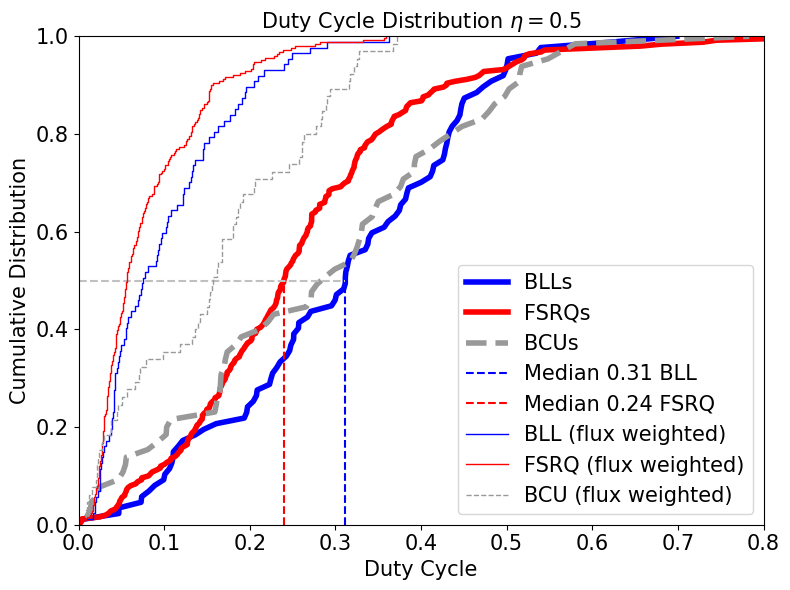

In [80]:
# comput the cumulative distribution of the duty cycle for all sources
dc_3_bll_sorted = np.sort(dc_3_bll['dc'])
dc_3_fsrq_sorted = np.sort(dc_3_fsrq['dc'])
dc_5_bll_sorted = np.sort(dc_5_bll['dc'])
dc_5_fsrq_sorted = np.sort(dc_5_fsrq['dc'])
dc_5_bcu_sorted = np.sort(dc_5_bcu['dc'])

dc_3_bll_cdf = np.arange(1, len(dc_3_bll_sorted)+1) / len(dc_3_bll_sorted)
dc_3_fsrq_cdf = np.arange(1, len(dc_3_fsrq_sorted)+1) / len(dc_3_fsrq_sorted)
dc_5_bll_cdf = np.arange(1, len(dc_5_bll_sorted)+1) / len(dc_5_bll_sorted)
dc_5_fsrq_cdf = np.arange(1, len(dc_5_fsrq_sorted)+1) / len(dc_5_fsrq_sorted)
dc_5_bcu_cdf = np.arange(1, len(dc_5_bcu_sorted)+1) / len(dc_5_bcu_sorted)


plt.figure(figsize=(8,6))
plt.plot(dc_5_bll_sorted, dc_5_bll_cdf, label=r'BLLs', color='blue', linestyle='-', lw=4)
plt.plot(dc_5_fsrq_sorted, dc_5_fsrq_cdf, label=r'FSRQs', color='red', linestyle='-', lw=4)
plt.plot(dc_5_bcu_sorted, dc_5_bcu_cdf, label=r'BCUs', color='0.6', linestyle='--', lw=4)
# mark the median duty cycle for bll and fsrq
plt.vlines(dc_5_bll_sorted[int(len(dc_5_bll_sorted)/2)], 0, 0.5, linestyle='--', color='blue', label=f'Median {dc_5_bll_sorted[int(len(dc_5_bll_sorted)/2)]:.2f} BLL')
plt.vlines(dc_5_fsrq_sorted[int(len(dc_5_fsrq_sorted)/2)], 0, 0.5, linestyle='--', color='red', label=f'Median {dc_5_fsrq_sorted[int(len(dc_5_fsrq_sorted)/2)]:.2f} FSRQ')
plt.hlines(0.5, 0, dc_5_bll_sorted[int(len(dc_5_bll_sorted)/2)], linestyle='--', color='silver')

plt.step(np.sort(flux_weighted_duty_cycles[iii_bll]), np.arange(1, len(flux_weighted_duty_cycles[iii_bll])+1)/len(flux_weighted_duty_cycles[iii_bll]), where='post', label='BLL (flux weighted)', color='blue', linewidth=1)
plt.step(np.sort(flux_weighted_duty_cycles[iii_fsrq]), np.arange(1, len(flux_weighted_duty_cycles[iii_fsrq])+1)/len(flux_weighted_duty_cycles[iii_fsrq]), where='post', label='FSRQ (flux weighted)', color='red', linewidth=1)
plt.step(np.sort(flux_weighted_duty_cycles[iii_bcu]), np.arange(1, len(flux_weighted_duty_cycles[iii_bcu])+1)/len(flux_weighted_duty_cycles[iii_bcu]), where='post', label='BCU (flux weighted)', color='0.6', linewidth=1, linestyle='--')

# plt.xscale('log')   
# plt.yscale('log')
plt.xlabel('Duty Cycle', size=15)
plt.ylabel('Cumulative Distribution', size=15)
plt.title(r'Duty Cycle Distribution $\eta=0.5$', size=15)
plt.legend(fontsize=15)
plt.xlim(0, 0.8)
plt.ylim(0, 1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.tight_layout()
# this figure shows the CDF of the duty cycle for bll and fsrq for eta=0.5.
plt.savefig('/Users/mnegro/MyDocuments/_FERMI/LCR/LCRanalyses/figs/DutyCycle_CDF_Rbkg0.10_Eta0.5.png', dpi=200)

In [ ]:
# get a spline of the cumulative distribution
import numpy as np
from scipy.interpolate import interp1d
dc_bll_spline = interp1d(dc_5_bll_sorted, dc_5_bll_cdf, kind='linear', fill_value='extrapolate')
dc_fsrq_spline = interp1d(dc_5_fsrq_sorted, dc_5_fsrq_cdf, kind='linear', fill_value='extrapolate') 
dc_ = np.linspace(0, 1, 1000)

#compute the max deviation between the two cumulative distributions
D = np.max(np.abs(dc_bll_spline(dc_) - dc_fsrq_spline(dc_)))
print('Max deviation between BLL and FSRQ cumulative distributions:', D)

m = len(dc_5_bll_sorted) 
n = len(dc_5_fsrq_sorted)
# factor = np.sqrt((len(dc_bll_sorted) + len(dc_fsrq_sorted)) / (len(dc_bll_sorted) * len(dc_fsrq_sorted)))
alpha_5sigma = 0.0000003 #5sigma
alpha_4sigma = 0.000063 #4sigma
alpha_3sigma = 0.003 #3sigma
alpha_2sigma = 0.05 #2sigma
D_alpha_2sigma = np.sqrt(-np.log(alpha_2sigma/2) / (1+(m/n))/(2*m))
print('D_alpha for alpha=0.05:', D_alpha_2sigma)
D_alpha_3sigma = np.sqrt(-np.log(alpha_3sigma/2) / (1+(m/n))/(2*m))
print('D_alpha for alpha=0.003:', D_alpha_3sigma)
D_alpha_4sigma = np.sqrt(-np.log(alpha_4sigma/2) / (1+(m/n))/(2*m))
print('D_alpha for alpha=0.000063:', D_alpha_4sigma)
D_alpha_5sigma = np.sqrt(-np.log(alpha_5sigma/2) / (1+(m/n))/(2*m))
print('D_alpha for alpha=0.0000003:', D_alpha_5sigma)

#repeat the test on the weighted duty cycles
flux_weighted_duty_cycles_bll = flux_weighted_duty_cycles[iii_bll]
flux_weighted_duty_cycles_fsrq = flux_weighted_duty_cycles[iii_fsrq]
flux_weighted_duty_cycles_bll_sorted = np.sort(flux_weighted_duty_cycles_bll)
flux_weighted_duty_cycles_fsrq_sorted = np.sort(flux_weighted_duty_cycles_fsrq)
flux_weighted_duty_cycles_bll_cdf = np.arange(1, len(flux_weighted_duty_cycles_bll_sorted)+1) / len(flux_weighted_duty_cycles_bll_sorted)
flux_weighted_duty_cycles_fsrq_cdf = np.arange(1, len(flux_weighted_duty_cycles_fsrq_sorted)+1) / len(flux_weighted_duty_cycles_fsrq_sorted)    
flux_weighted_dc_bll_spline = interp1d(flux_weighted_duty_cycles_bll_sorted, flux_weighted_duty_cycles_bll_cdf, kind='linear', fill_value='extrapolate')
flux_weighted_dc_fsrq_spline = interp1d(flux_weighted_duty_cycles_fsrq_sorted, flux_weighted_duty_cycles_fsrq_cdf, kind='linear', fill_value='extrapolate') 
dc_fw_ = np.linspace(0, min(flux_weighted_duty_cycles_bll_sorted[-1], flux_weighted_duty_cycles_fsrq_sorted[-1]), 1000)
D_fw = np.max(np.abs(flux_weighted_dc_bll_spline(dc_fw_) - flux_weighted_dc_fsrq_spline(dc_fw_)))
print('Max deviation between BLL and FSRQ cumulative distributions (flux weighted):', D_fw)
m_fw = len(flux_weighted_duty_cycles_bll_sorted) 
n_fw = len(flux_weighted_duty_cycles_fsrq_sorted)
D_alpha_2sigma_fw = np.sqrt(-np.log(alpha_2sigma/2) / (1+(m_fw/n_fw))/(2*m_fw))
print('D_alpha for 2 sigma (alpha=0.05) (flux weighted):', D_alpha_2sigma_fw)
D_alpha_3sigma_fw = np.sqrt(-np.log(alpha_3sigma/2) / (1+(m_fw/n_fw))/(2*m_fw))
print('D_alpha for 3 sigma (alpha=0.003) (flux weighted):', D_alpha_3sigma_fw)
D_alpha_4sigma_fw = np.sqrt(-np.log(alpha_4sigma/2) / (1+(m_fw/n_fw))/(2*m_fw))
print('D_alpha for 4 sigma (alpha=0.000063) (flux weighted):', D_alpha_4sigma_fw)
D_alpha_5sigma_fw = np.sqrt(-np.log(alpha_5sigma/2) / (1+(m_fw/n_fw))/(2*m_fw))
print('D_alpha for 5 sigma (alpha=0.0000003) (flux weighted):', D_alpha_5sigma_fw)

# ΔDC=DC weighted −DC unweighted and compare median(ΔDC) (and its CI) between classes (e.g., Mann–Whitney U test). 
# If ∣ΔDC∣ is larger for BLLs, then you can state that weighting reduces their duty cycles more.
delta_dc_bll = np.abs(flux_weighted_duty_cycles_bll_sorted - np.sort(duty_cycles[iii_bll]))
delta_dc_fsrq = np.abs(flux_weighted_duty_cycles_fsrq_sorted - np.sort(duty_cycles[iii_fsrq]))
# compute the median and 68% confidence interval
median_delta_dc_bll = np.median(delta_dc_bll)
median_delta_dc_fsrq = np.median(delta_dc_fsrq)
ci_bll = np.percentile(delta_dc_bll, [16, 84])
ci_fsrq = np.percentile(delta_dc_fsrq, [16, 84])
print('Median ΔDC for BLL:', median_delta_dc_bll, '68% CI:', ci_bll)
print('Median ΔDC for FSRQ:', median_delta_dc_fsrq, '68% CI:', ci_fsrq) 
# also perfom the Mann-Whitney U test
from scipy.stats import mannwhitneyu
u_stat, p_value = mannwhitneyu(delta_dc_bll, delta_dc_fsrq, alternative='two-sided')
print('Mann-Whitney U test between ΔDC of BLL and FSRQ:')
print('U statistic:', u_stat)
print('p-value:', p_value)


Max deviation between BLL and FSRQ cumulative distributions: 0.23858730660582678
D_alpha for alpha=0.05: 0.12540869872443347
D_alpha for alpha=0.003: 0.16649975659764027
D_alpha for alpha=0.000063: 0.21022097200986264
D_alpha for alpha=0.0000003: 0.25882419933302797
Max deviation between BLL and FSRQ cumulative distributions (flux weighted): 0.15498419939004437
D_alpha for 2 sigma (alpha=0.05) (flux weighted): 0.1254732416232218
D_alpha for 3 sigma (alpha=0.003) (flux weighted): 0.16658544743924586
D_alpha for 4 sigma (alpha=0.000063) (flux weighted): 0.21032916443237892
D_alpha for 5 sigma (alpha=0.0000003) (flux weighted): 0.2589574059149592
Median ΔDC for BLL: 0.2312651087832393 68% CI: [0.08717012 0.26924583]
Median ΔDC for FSRQ: 0.1816737544766729 68% CI: [0.0959278  0.22905878]
Mann-Whitney U test between ΔDC of BLL and FSRQ:
U statistic: 14156.5
p-value: 3.756527129793365e-05


(0.0, 1.0)

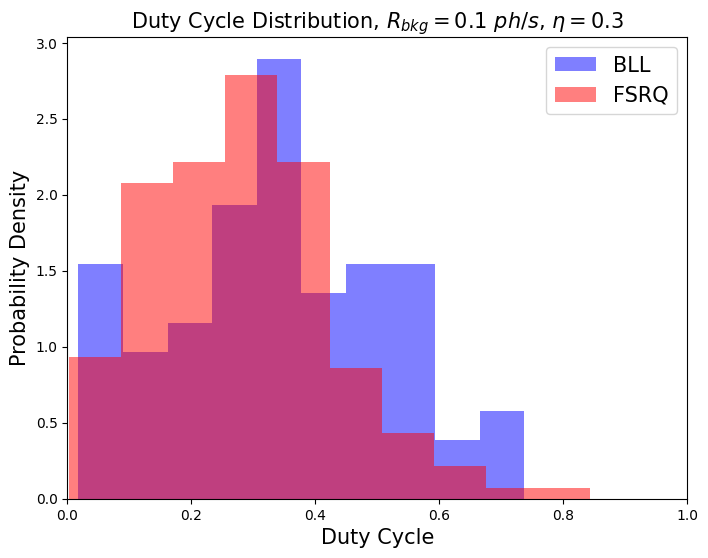

In [ ]:
# # plot the pdf of the duty cycle
# plt.figure(figsize=(8,6))
# plt.hist(dc_bll['dc'], bins=10, density=True, alpha=0.5, label='BLL', color='blue')
# plt.hist(dc_fsrq['dc'], bins=10, density=True, alpha=0.5, label='FSRQ', color='red')
# plt.xlabel('Duty Cycle', size=15)
# plt.ylabel('Probability Density', size=15)
# plt.title(r'Duty Cycle Distribution, $R_{bkg}=0.1~ph/s$, $\eta=0.3$', size=15)
# plt.legend(fontsize=15)
# plt.xlim(0, 1)  